# Classification of Chest X-ray images using Vision Transformers

## Importing necessary packages

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import pandas as pd
import matplotlib.pyplot as plt

## Create datasets and set hyperparameters

In [ ]:
num_classes = 2
num_color_channels = 1
input_shape = (1024, 1024, num_color_channels)

image_size = 256  # Resizes input images to this size
batch_size = 32

input_shape_resized = (image_size, image_size, num_color_channels)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./train_data",
    labels="inferred",
    label_mode="int",
    class_names=["effusion", "no_effusion"],
    color_mode="grayscale",
    batch_size = batch_size,
    image_size = (image_size,image_size),
    validation_split=0.1,
    seed=2222,
    subset="training",
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./train_data",
    labels="inferred",
    label_mode="int",
    class_names=["effusion", "no_effusion"],
    color_mode="grayscale",
    batch_size = batch_size,
    image_size = (image_size,image_size),
    validation_split=0.1,
    seed=2222,
    subset="validation",
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./test_data",
    labels="inferred",
    label_mode="int",
    class_names=["effusion", "no_effusion"],
    color_mode="grayscale",
    batch_size = batch_size,
    image_size = (image_size,image_size),
)

Found 3025 files belonging to 2 classes.
Using 2723 files for training.
Found 3025 files belonging to 2 classes.
Using 302 files for validation.
Found 553 files belonging to 2 classes.


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100
patch_size = 16  # Size of the patches to be extracted from the input images
dropout = 0.1
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Define functions and layers to use in the network

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(mean=0.5, variance=0.5),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Visualization of training data

No Effusion
Image size: 256 X 256
Patch size: 85 X 85
Patches per image: 9
Elements per patch: 7225


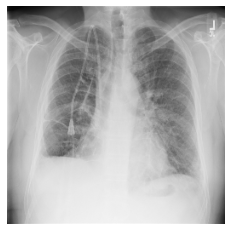

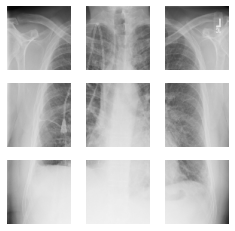

In [ ]:
for element in train_ds:
    greyscale = element[0].numpy()[0]
    one_channel = np.squeeze(greyscale)/255
    three_channels = np.stack((one_channel,)*3, axis=-1)
    plt.imshow(three_channels)
    plt.axis("off")
    print(["No Effusion", "Effusion"][element[1][0]])

    patches = Patches(patch_size)(element[0])
  
    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size))
        one_channel = patch_img.numpy().astype("uint8")
        three_channels = np.stack((one_channel,)*3, axis=-1)
        plt.imshow(three_channels)
        plt.axis("off")
        break

## Define Classifier Network

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape_resized)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(dropout)(representation) #0.5
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=dropout)#0.5
    # Classify outputs.
    logits = layers.Dense(1, activation=tf.nn.sigmoid)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Run experiment

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_ds,
        validation_data = validation_ds,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/143
86/86 [==============================] - 21s 102ms/step - loss: 1.1000 - accuracy: 0.5633 - val_loss: 0.6541 - val_accuracy: 0.6424
Epoch 2/143
86/86 [==============================] - 8s 83ms/step - loss: 0.6756 - accuracy: 0.5872 - val_loss: 0.7289 - val_accuracy: 0.4338
Epoch 3/143
86/86 [==============================] - 8s 80ms/step - loss: 0.6818 - accuracy: 0.5858 - val_loss: 0.6669 - val_accuracy: 0.6258
Epoch 4/143
86/86 [==============================] - 8s 83ms/step - loss: 0.6518 - accuracy: 0.6254 - val_loss: 0.6331 - val_accuracy: 0.6258
Epoch 5/143
86/86 [==============================] - 7s 80ms/step - loss: 0.6401 - accuracy: 0.6265 - val_loss: 0.6328 - val_accuracy: 0.6424
Epoch 6/143
86/86 [==============================] - 7s 79ms/step - loss: 0.6451 - accuracy: 0.6298 - val_loss: 0.6406 - val_accuracy: 0.6325
Epoch 7/143
86/86 [==============================] - 8s 85ms/step - loss: 0.6346 - accuracy: 0.6386 - val_loss: 0.6258 - val_accuracy: 0.6523
Epoc

## Visualize training loss and accuracy

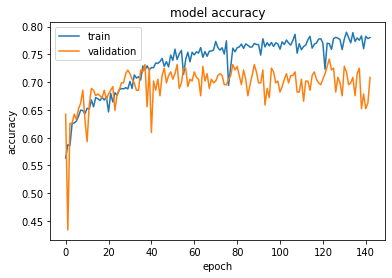

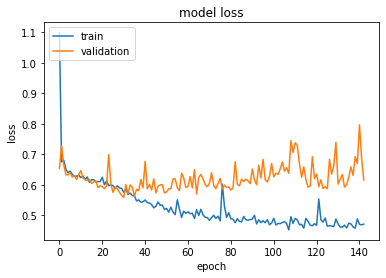

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Results

 <table style="width:100%">
  <tr>
    <th>Run</th>
    <th>Image Size</th>
    <th>Batch Size</th>
    <th>Patch Size</th>
    <th>Learning Rate</th>
    <th>Weight Decay</th>
    <th>Number of Epochs</th>
    <th>Dropout</th>
    <th>Result (validation set)</th>
    <th>Result (test set)</th>
  </tr>
  <tr>
    <td>1</td>
    <td>128</td>
    <td>1</td>
    <td>6</td>
    <td>0.0001</td>
    <td>0</td>
    <td>20</td>
    <td>0.5</td>
    <td>66.23%</td>
    <td></td>
  </tr>
  <tr>
    <td>2</td>
    <td>128</td>
    <td>4</td>
    <td>4</td>
    <td>0.0001</td>
    <td>0.0006184</td>
    <td>50</td>
    <td>0.5</td>
    <td>64.24%</td>
    <td></td>
  </tr>
  <tr>
    <td>3</td>
    <td>128</td>
    <td>2</td>
    <td>4</td>
    <td>1e-05</td>
    <td>0.0008492</td>
    <td>63</td>
    <td>0.5</td>
    <td>64.24%</td>
    <td></td>
  </tr>
  <tr>
    <td>4</td>
    <td>64</td>
    <td>8</td>
    <td>10</td>
    <td>0.001</td>
    <td>0.0009972</td>
    <td>68</td>
    <td>0.5</td>
    <td>65.23%</td>
    <td></td>
  </tr>
  <tr>
    <td>5</td>
    <td>64</td>
    <td>8</td>
    <td>6</td>
    <td>0.0001</td>
    <td>0.0007106</td>
    <td>94</td>
    <td>0.5</td>
    <td>65.89%</td>
    <td></td>
  </tr>
  <tr>
    <td>6</td>
    <td>256</td>
    <td>4</td>
    <td>8</td>
    <td>0.0001</td>
    <td>0.0004487</td>
    <td>15</td>
    <td>0.5</td>
    <td>64.57%</td>
    <td></td>
  </tr>
  <tr>
    <td>7</td>
    <td>64</td>
    <td>4</td>
    <td>16</td>
    <td>0.0001</td>
    <td>0.0004636</td>
    <td>70</td>
    <td>0.5</td>
    <td>64.57%</td>
    <td></td>
  </tr>
  <tr>
    <td>8</td>
    <td>256</td>
    <td>64</td>
    <td>16</td>
    <td>0.0001</td>
    <td>0</td>
    <td>100</td>
    <td>0.1</td>
    <td>75.17%</td>
    <td></td>
  </tr>
  <tr>
    <td>9</td>
    <td>128</td>
    <td>64</td>
    <td>16</td>
    <td>1e-05</td>
    <td>0</td>
    <td>158</td>
    <td>0.01</td>
    <td>75.83%</td>
    <td>70.89%</td>
  </tr>
  <tr>
    <td>10</td>
    <td>128</td>
    <td>32</td>
    <td>8</td>
    <td>0.001</td>
    <td>0.0002606</td>
    <td>125</td>
    <td>0.073</td>
    <td>74.17%</td>
    <td></td>
  </tr>
  <tr>
    <td>11</td>
    <td>256</td>
    <td>16</td>
    <td>12</td>
    <td>1e-06</td>
    <td>0.0008477</td>
    <td>158</td>
    <td>0.42</td>
    <td>64.24%</td>
    <td></td>
  </tr>
  <tr>
    <td>12</td>
    <td>64</td>
    <td>32</td>
    <td>10</td>
    <td>0.001</td>
    <td>0.0004878</td>
    <td>143</td>
    <td>0.22</td>
    <td>74.17%</td>
    <td></td>
  </tr>
</table>